In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:

catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values

# Preview original and noisy images

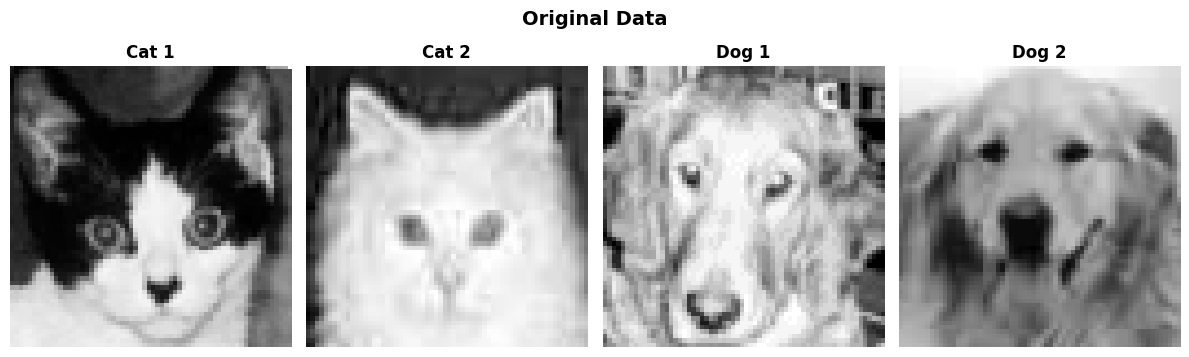

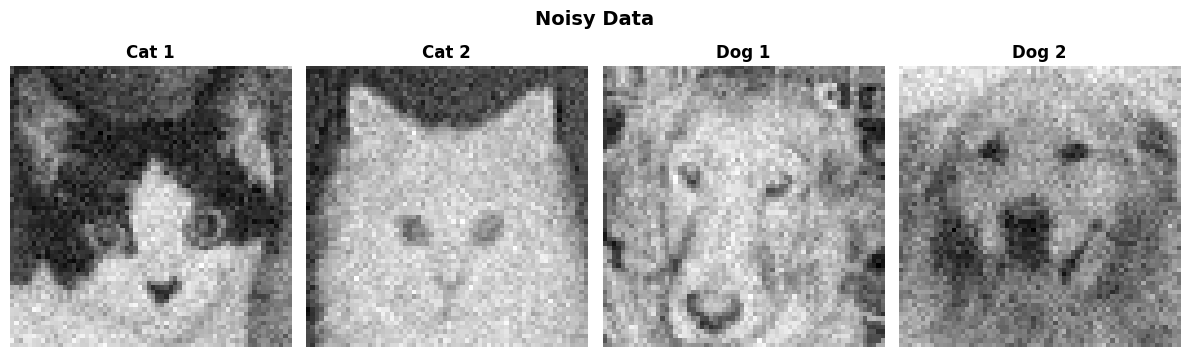

In [3]:
def rotate_matrix(x):
    return np.flip(x.T, axis=1)

np.random.seed(1042212)

cats_indices = np.where(labels == 0)[0]
dogs_indices = np.where(labels == 1)[0]

sample_cats = np.random.choice(cats_indices, 2, replace=False)
sample_dogs = np.random.choice(dogs_indices, 2, replace=False)

gray_scale = LinearSegmentedColormap.from_list("grayscale", [(i/255, i/255, i/255) for i in range(256)], N=256)

def add_noise(dataset, noise_level):
  return dataset + noise_level*np.random.normal(0, 1, dataset.shape)

# Plot original data
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
titles = ['Cat 1', 'Cat 2', 'Dog 1', 'Dog 2']
for i, idx in enumerate([sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]):
    axs[i].imshow(rotate_matrix(catsndogs[idx].reshape(64, 64)), cmap=gray_scale)
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)
fig.suptitle('Original Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()

# Add noise and plot noisy data
catsndogs_noisy_for_preview = add_noise(catsndogs, noise_level=20)

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
for i, idx in enumerate([sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]):
    axs[i].imshow(rotate_matrix(catsndogs_noisy_for_preview[idx].reshape(64, 64)), cmap=gray_scale)
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)
fig.suptitle('Noisy Data', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()

# Standardized data and PCA

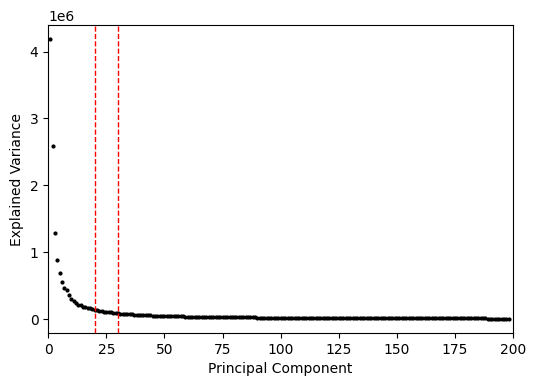

In [4]:
pca = PCA()
scaler = StandardScaler()
catsndogs_stadardized = scaler.fit_transform(catsndogs)
catsndogs_pca = pca.fit_transform(catsndogs)

#Elbow method
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.axvline(20, linestyle="dashed", color="red", linewidth=1)
ax.axvline(30, linestyle="dashed", color="red", linewidth=1)
plt.xlim(0, 200)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance");

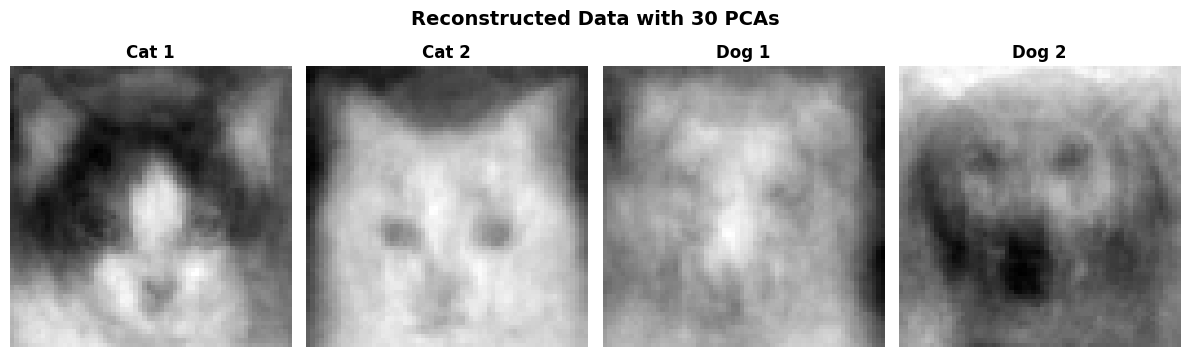

In [5]:
catsndogs = pd.read_csv("CATSnDOGS.csv").values

# Standardize
scaler = StandardScaler()
catsndogs_standardized = scaler.fit_transform(catsndogs)

# PCA
pca = PCA(n_components=20)
catsndogs_pca = pca.fit_transform(catsndogs_standardized)

# Reconstruct images from the PCA components
catsndogs_reconstructed = pca.inverse_transform(catsndogs_pca)
catsndogs_reconstructed = scaler.inverse_transform(catsndogs_reconstructed)

# Reconstructed images:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
titles = ['Cat 1', 'Cat 2', 'Dog 1', 'Dog 2']
sample_indices = [sample_cats[0], sample_cats[1], sample_dogs[0], sample_dogs[1]]

for i, idx in enumerate(sample_indices):
    image = catsndogs_reconstructed[idx].reshape(64, 64)
    axs[i].imshow(rotate_matrix(image), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(titles[i], fontweight='bold', fontsize=12)

fig.suptitle('Reconstructed Data with 30 PCAs', fontsize=14, fontweight='bold', verticalalignment='top', y=0.8)
plt.tight_layout()
plt.show()


# Train raw RandomForest, with Gradient Boosting and with Bagging, with and without PCA

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [25,50,100, 200],  # Number of trees
    
}

# Set up GridSearchCV with cross-validation and a scoring method
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5, 
    verbose=1,  # Print progress during grid search
    n_jobs=-1  # Use multiple cores for faster execution
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train a model with the best parameters
best_rf = grid_search.best_estimator_

# Test the model on the test set
y_pred = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 100}
Test Set Accuracy: 0.725


In [7]:

X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels.ravel(), test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(random_state=42)


param_grid = {
    'n_estimators': [10,25,50,100]  # Number of trees
    
}

# Set up GridSearchCV with cross-validation and a scoring method
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='accuracy',  
    cv=5,  
    verbose=1,  # Print progress during grid search
    n_jobs=-1  # Use multiple cores for faster execution
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train a model with the best parameters
best_gb = grid_search.best_estimator_

# Test the model on the test set
y_pred = best_gb.predict(X_test)

# Calculate accuracy or other metrics
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'n_estimators': 100}
Test Set Accuracy: 0.725


In [8]:
rf = best_rf
gb = best_gb
bagging = BaggingClassifier(estimator = RandomForestClassifier(n_estimators=10), n_estimators=10, random_state=42)

# Evaluate accuracies over noise levels

In [9]:
def accuracy_over_data(data, title):
  catsndogs = data
  noise_levels = np.linspace(0, 200, 21)

  accuracy_over_noise_rf = []
  accuracy_over_noise_boosting = []
  accuracy_over_noise_bagging = []
  

  for noise_level in noise_levels:
    # Choose noise and split
    X_current = add_noise(catsndogs, noise_level)
    X_train, X_test, y_train, y_test = train_test_split(X_current, labels.ravel(), test_size=0.2, random_state=42)

    # Raw RandomForest
    rf.fit(X_train,y_train)
    y_pred_rf = rf.predict(X_test)
    accuracy_over_noise_rf.append(accuracy_score(y_test, y_pred_rf))

    # RandomForest with Gradient Boosting
    gb.fit(X_train, y_train)
    y_pred_boosting = gb.predict(X_test)
    accuracy_over_noise_boosting.append(accuracy_score(y_test, y_pred_boosting))

    # RandomForest with Bagging
    bagging.fit(X_train, y_train)
    y_pred_bagging = bagging.predict(X_test)
    accuracy_over_noise_bagging.append(accuracy_score(y_test, y_pred_bagging))

  plt.figure(figsize=(10,6))
  plt.plot(noise_levels, accuracy_over_noise_rf, label='Raw RandomForest')
  plt.plot(noise_levels, accuracy_over_noise_boosting, label='RandomForest with Boosting')
  plt.plot(noise_levels, accuracy_over_noise_bagging, label='RandomForest with Bagging')
  plt.axhline(y=0.5, linestyle='--', color='grey', label='Guessing threshold')
  plt.xlabel('Noise level (standard deviation)')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

# Part 1: Get Feature Importance

In [12]:
def feature_importance_over_data(data):
  catsndogs = data
  noise_levels = [0,30,100]

  rf_feature_importance_over_noise_rf = []
  gb_feature_importance_noise_boosting = []

  accuracy_over_noise_rf = []
  accuracy_over_noise_boosting = []

  for noise_level in noise_levels:
    # Choose noise and split
    X_current = add_noise(catsndogs, noise_level)
    X_train, X_test, y_train, y_test = train_test_split(X_current, labels.ravel(), test_size=0.2, random_state=42)

    # Raw RandomForest
    rf.fit(X_train,y_train)
    y_pred_rf = rf.predict(X_test)
    accuracy_over_noise_rf.append(accuracy_score(y_test, y_pred_rf))
    rf_feature_importance = pd.Series(rf.feature_importances_)
    rf_feature_importance_over_noise_rf.append(rf_feature_importance)

    # RandomForest with Gradient Boosting
    gb.fit(X_train, y_train)
    y_pred_boosting = gb.predict(X_test)
    accuracy_over_noise_boosting.append(accuracy_score(y_test, y_pred_boosting))
    boosting_feature_importance = pd.Series(gb.feature_importances_)
    gb_feature_importance_noise_boosting.append(boosting_feature_importance)

    print("Noise level : ", noise_level)
    print("Random Forest Feature Importance:\n", rf.feature_importances_)
    print("Gradient Boosting Feature Importance:\n", gb.feature_importances_)

  return rf_feature_importance_over_noise_rf, gb_feature_importance_noise_boosting 


In [28]:
rf_feature_importance_over_noise, gb_feature_importance_over_noise  = feature_importance_over_data(data=catsndogs)

Noise level :  0
Random Forest Feature Importance:
 [0.00052376 0.         0.         ... 0.         0.00023512 0.        ]
Gradient Boosting Feature Importance:
 [0. 0. 0. ... 0. 0. 0.]
Noise level :  30
Random Forest Feature Importance:
 [0.       0.000434 0.       ... 0.       0.       0.      ]
Gradient Boosting Feature Importance:
 [5.21356715e-08 0.00000000e+00 0.00000000e+00 ... 1.08195963e-05
 0.00000000e+00 0.00000000e+00]
Noise level :  100
Random Forest Feature Importance:
 [0.         0.         0.         ... 0.         0.         0.00106171]
Gradient Boosting Feature Importance:
 [0. 0. 0. ... 0. 0. 0.]


RF : Feature Importance at Noise Level: 0
Number of non-zero importance value : 1109
Mean : 0.000244 Min : 0.0 Max : 0.010082 Std : 0.000672
--------------------------------------------------------------------
GB : Feature Importance at Noise Level: 0
Number of non-zero importance value : 404
Mean : 0.000244 Min : 0.0 Max : 0.151612  Std : 0.003655
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
RF : Feature Importance at Noise Level: 30
Number of non-zero importance value : 1117
Mean : 0.000244 Min : 0.0 Max : 0.012073 Std : 0.000698
--------------------------------------------------------------------
GB : Feature Importance at Noise Level: 30
Number of non-zero importance value : 346
Mean : 0.000244 Min : 0.0 Max : 0.122449  Std : 0.002987
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
RF : Feature Importance at Noise Level: 100
Number of non-zero importance value : 1135
Mean : 0.000244 Min : 0.0 Max : 0.008419 Std : 0.000600
-------------

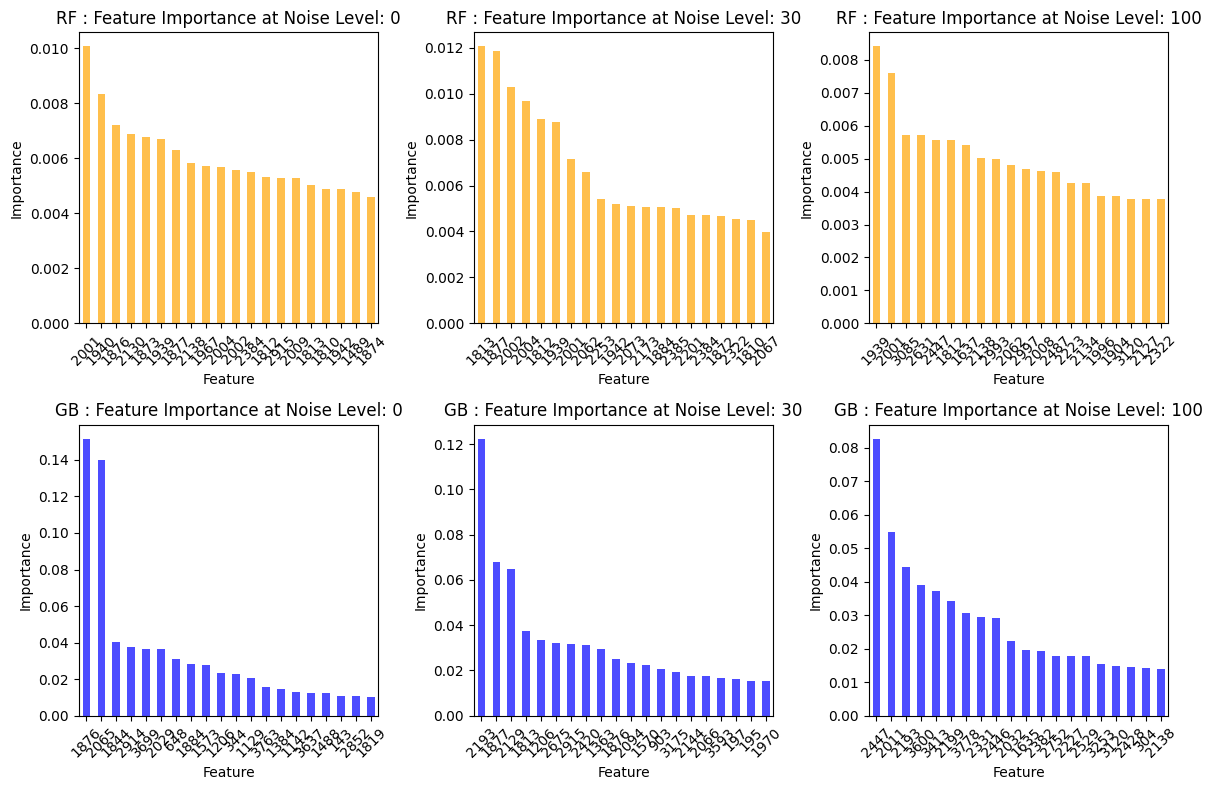

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Noise levels
noise_levels = [0, 30, 100]

# Data for Gradient Boosting (GB)
gb_non_zero = []
gb_std = []
gb_mean = []
gb_max = []

# Data for Random Forest (RF)
rf_non_zero = []
rf_std = []
rf_mean = []
rf_max = []
# Number of rows and columns for the subplot grid
n_rows = 2
n_cols = 3

# Start subplot index
plot_idx = 1

# Create a new figure
plt.figure(figsize=(12, 8))

# Loop through the noise levels and plot feature importance for Random Forest and Gradient Boosting
for i in range(len(noise_levels)):
    # Random Forest plots
    plt.subplot(n_rows, n_cols, plot_idx)  # Position the subplot
    rf_feature_importance_over_noise[i].sort_values(ascending=False)[:20].plot(
        kind='bar', color='orange', alpha=0.7
    )
    rf_fi = np.array(rf_feature_importance_over_noise[i])
    plt.title(f"RF : Feature Importance at Noise Level: {noise_levels[i]}")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    zero_importance_feature_rf = sum(importance != 0 for importance in rf_fi)
    rf_non_zero.append(zero_importance_feature_rf)
    rf_std.append(np.std(rf_fi))
    rf_mean.append(np.mean(rf_fi))
    rf_max.append(np.max(rf_fi))
    print(f"RF : Feature Importance at Noise Level: {noise_levels[i]}")
    print(f"Number of non-zero importance value : {zero_importance_feature_rf}")
    print(f"Mean : {np.mean(rf_fi):.6f} Min : {np.min(rf_fi)} Max : {np.max(rf_fi):.6f} Std : {np.std(rf_fi):.6f}")
    print("--------------------------------------------------------------------")
    # Gradient Boosting plots
    plt.subplot(n_rows, n_cols, plot_idx + 3)  # Position the subplot
    gb_feature_importance_over_noise[i].sort_values(ascending=False)[:20].plot(
        kind='bar', color='blue', alpha=0.7
    )
    gb_fi = np.array(gb_feature_importance_over_noise[i])
    plt.title(f"GB : Feature Importance at Noise Level: {noise_levels[i]}")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    zero_importance_feature_gb = sum(importance != 0 for importance in gb_fi)
    gb_non_zero.append(zero_importance_feature_gb)
    gb_std.append(np.std(gb_fi))
    gb_mean.append(np.mean(gb_fi))
    gb_max.append(np.max(gb_fi))
    print(f"GB : Feature Importance at Noise Level: {noise_levels[i]}")
    print(f"Number of non-zero importance value : {zero_importance_feature_gb}")
    print(f"Mean : {np.mean(gb_fi):.6f} Min : {np.min(gb_fi)} Max : {np.max(gb_fi):.6f}  Std : {np.std(gb_fi):.6f}")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    # Increment the subplot index
    plot_idx += 1

# Adjust subplot spacing to avoid title overlap
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Increase horizontal and vertical spacing between subplots
plt.tight_layout()  # Further ensure spacing adjustments are applied

# Show the plot
plt.show()


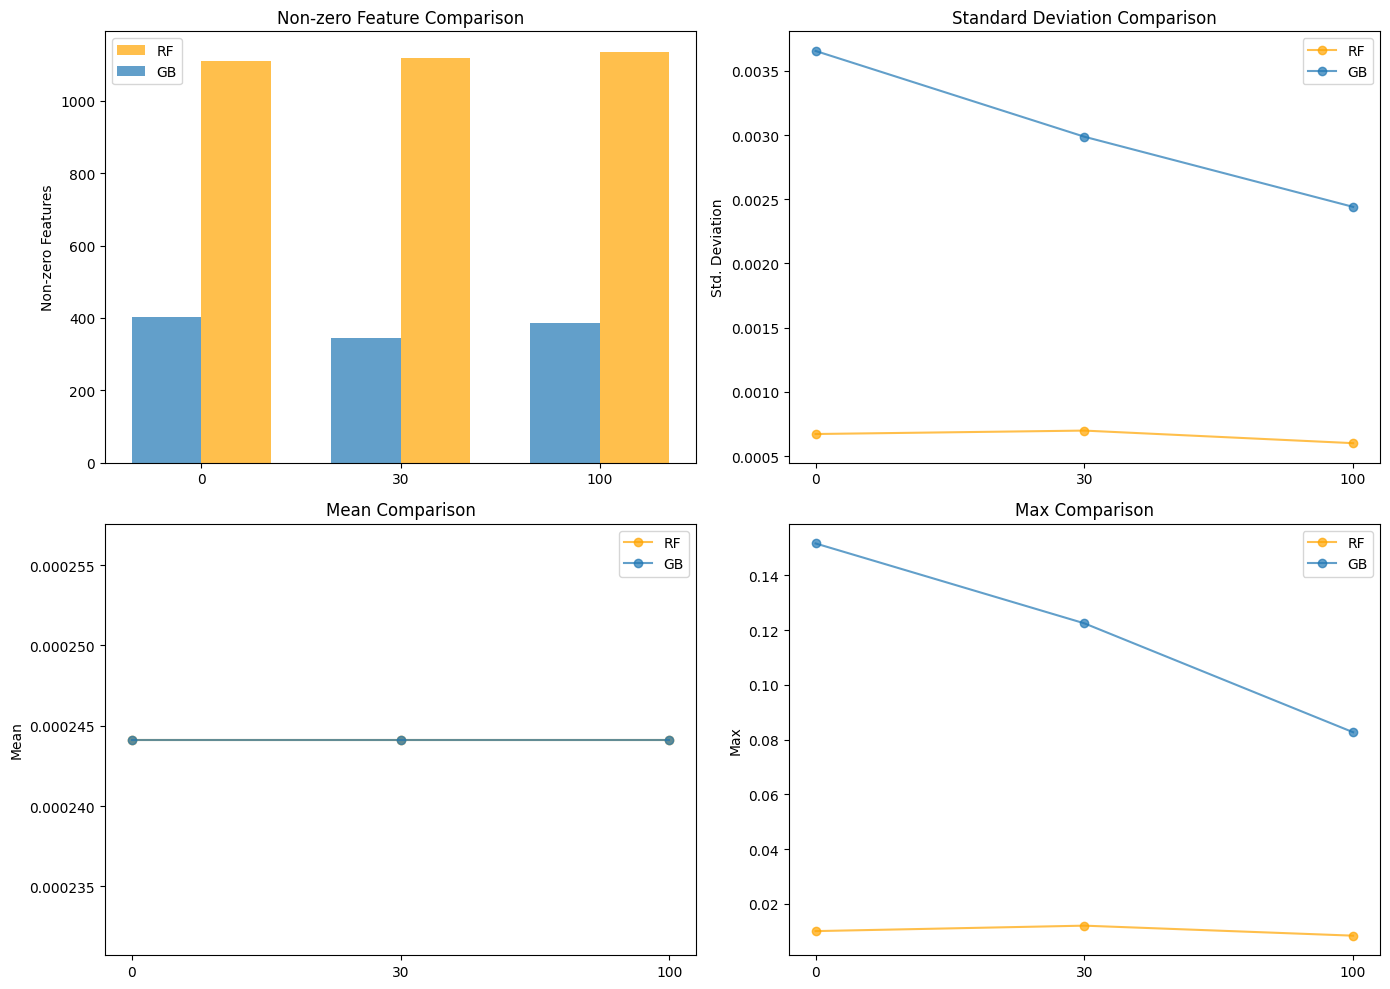

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Noise levels
noise_levels = ['0', '30', '100']



# Indices for the groups
ind = np.arange(len(noise_levels))  # the x locations for the groups
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 subplot grid

# Non-zero feature count comparison
ax[0, 0].bar(ind + width/2, rf_non_zero, width, label='RF',color = 'orange', alpha = 0.7)
ax[0, 0].bar(ind - width/2, gb_non_zero, width, label='GB', alpha = 0.7)

ax[0, 0].set_ylabel('Non-zero Features')
ax[0, 0].set_title('Non-zero Feature Comparison')
ax[0, 0].set_xticks(ind)
ax[0, 0].set_xticklabels(noise_levels)
ax[0, 0].legend()

# Standard Deviation Comparison
ax[0, 1].plot(ind, rf_std, marker='o', linestyle='-', label='RF',color = 'orange', alpha=0.7)
ax[0, 1].plot(ind, gb_std, marker='o', linestyle='-', label='GB', alpha=0.7)
ax[0, 1].set_ylabel('Std. Deviation')
ax[0, 1].set_title('Standard Deviation Comparison')
ax[0, 1].set_xticks(ind)
ax[0, 1].set_xticklabels(noise_levels)
ax[0, 1].legend()

# Mean Comparison
ax[1, 0].plot(ind, rf_mean, marker='o', linestyle='-', label='RF',color = 'orange', alpha=0.7)
ax[1, 0].plot(ind, gb_mean, marker='o', linestyle='-', label='GB', alpha=0.7)
ax[1, 0].set_ylabel('Mean')
ax[1, 0].set_title('Mean Comparison')
ax[1, 0].set_xticks(ind)
ax[1, 0].set_xticklabels(noise_levels)
ax[1, 0].legend()

# Max Comparison
ax[1, 1].plot(ind, rf_max, marker='o', linestyle='-', label='RF',color = 'orange', alpha=0.7)
ax[1, 1].plot(ind, gb_max, marker='o', linestyle='-', label='GB', alpha=0.7)
ax[1, 1].set_ylabel('Max')
ax[1, 1].set_title('Max Comparison')
ax[1, 1].set_xticks(ind)
ax[1, 1].set_xticklabels(noise_levels)
ax[1, 1].legend()


# Layout adjustment
plt.tight_layout()
plt.show()


In [60]:
overlap_count = []
for i in range(len(noise_levels)):
    print("Noise level : ", noise_levels[i])
    # Correlation between RF and GB feature importance
    #correlation = rf_feature_importance_over_noise[i].corr(gb_feature_importance_over_noise[i])
    #print("Correlation between RF and GB feature importance:", correlation)

    # Top 50 features from Random Forest and Gradient Boosting
    top_rf = rf_feature_importance_over_noise[i].nlargest(50)
    top_gb = gb_feature_importance_over_noise[i].nlargest(50)

    # Check overlap between top features
    overlap = set(top_rf.index).intersection(set(top_gb.index))
    print("Overlap between top features:", overlap)
    common_features_counts = len(overlap)
    overlap_count.append(common_features_counts)
    

Noise level :  0
Overlap between top features: {1940, 1877, 1876}
Noise level :  30
Overlap between top features: {1741, 2066, 2322, 1876, 1813, 1877}
Noise level :  100
Overlap between top features: {2529, 2447, 3120, 2961, 1939, 2134, 2138}


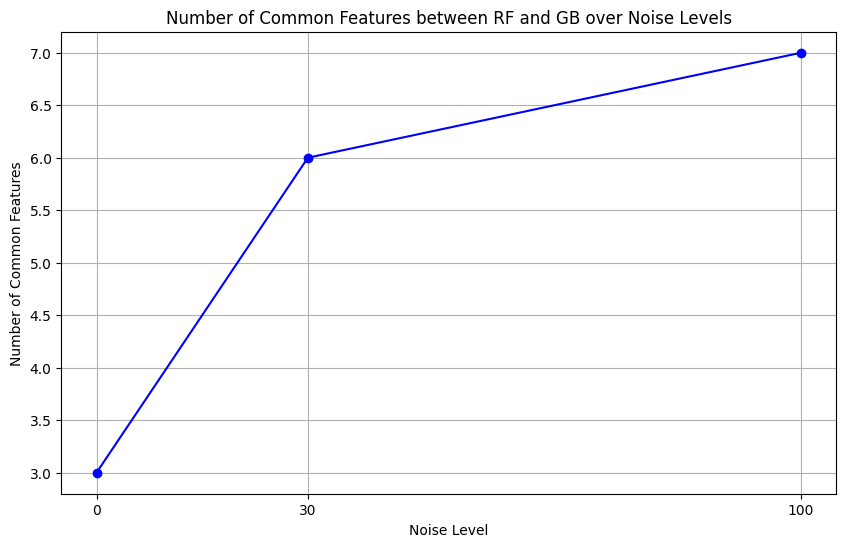

In [61]:
# plot the number of common features for each noise level
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, overlap_count, marker='o', linestyle='-', color='b')
plt.title('Number of Common Features between RF and GB over Noise Levels')
plt.xlabel('Noise Level')
#plt.ylim((0,8))
plt.ylabel('Number of Common Features')
plt.grid(True)
plt.xticks(noise_levels)
plt.show()


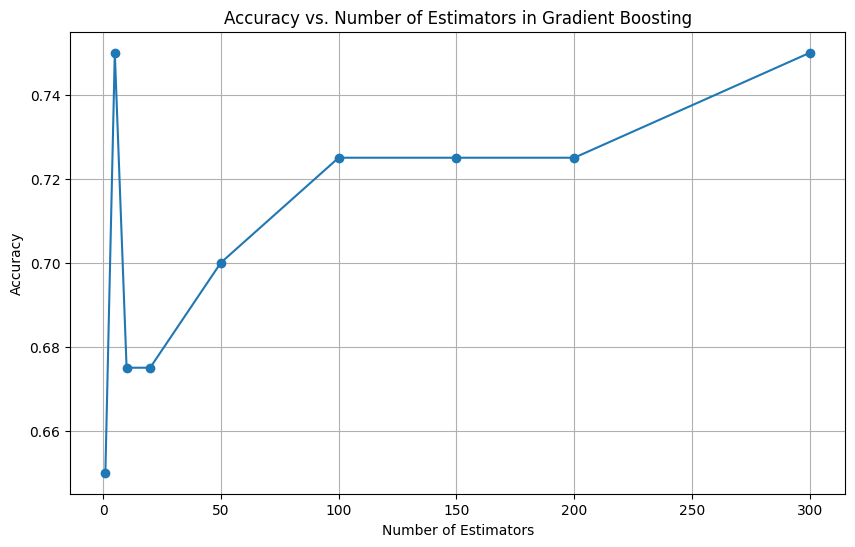

In [ ]:
# Load data
catsndogs = pd.read_csv("CATSnDOGS.csv").values
labels = pd.read_csv("Labels.csv").values.ravel()  # Flatten the labels array if needed

# Split the data
X_train, X_test, y_train, y_test = train_test_split(catsndogs, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Number of estimators to evaluate
n_estimators_options = [1, 5, 10, 20, 50, 100, 150, 200, 300]
accuracies = []

for n_estimators in n_estimators_options:
    boosting = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_options, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Estimators in Gradient Boosting')
plt.grid(True)
plt.show()
